# Data Analysis
for model selection and results analysis 

## Libraries and imports

In [6]:
import sys
sys.path.append('..')
from scripts.utils import initialize_bucket, plot_importance

from datetime import date

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, explained_variance_score,mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import shap

import pickle
import json

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
pd.set_option("display.max_columns", 400)

credentials_path = '../datascience-capstone-project-05b1642f45c3.json'

In [8]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/05_datasets/df_base_dataset.parquet"
df =  pd.read_parquet(path)

path = "gs://storage-barsianize/05_datasets/df_to_pred.parquet"
df_to_pred =  pd.read_parquet(path)

## Methods and functions

In [9]:
def load_model(path, model_name):
    """Load a trained model and associated preprocessing transformer.

    This function loads a trained machine learning model and identifies the appropriate
    estimator (LightGBM Regressor or XGBoost Regressor) from the pipeline steps. It also
    identifies any preprocessing transformers used in the pipeline.

    Args:
        path (str): The path to the directory containing the model file.
        model_name (str): The name of the model file.

    Returns:
        tuple: A tuple containing the loaded estimator and the preprocessing transformer.

    Raises:
        FileNotFoundError: If the specified model file does not exist.
    """
    with open(path + model_name, 'rb') as file:
        model = pickle.load(file)

    loaded_model = None
    for step_name, step_model in model.named_steps.items():
        if isinstance(step_model, LGBMRegressor):
            loaded_model = step_model
            break
        elif isinstance(step_model, XGBRegressor):
            loaded_model = step_model
            break
        elif step_name == 'preprocessing':
            transformer = step_model

    return loaded_model, transformer

In [10]:
def make_predictions(path, model_name, results_file, X_to_pred):
    """Make predictions using a trained model and return necessary components.

    This function loads a trained pipeline model and other relevant components,
    and then uses the model to predict target values for the provided data.

    Args:
        path (str): The path to the directory where the model and results file are located.
        model_name (str): The filename of the trained model in pickle format.
        results_file (str): The filename of the JSON results file containing features information.
        X_to_pred (pandas.DataFrame): The input data for which predictions need to be made.

    Returns:
        tuple: A tuple containing the following items:
            - predictions (numpy.ndarray): Predicted target values for the input data.
            - pipeline (sklearn.pipeline.Pipeline): The loaded pipeline model.
            - model: The trained machine learning model.
            - transformer: The data transformer used in the pipeline.
            - features (list): List of selected feature names used for predictions.

    Raises:
        FileNotFoundError: If the specified model file or results file does not exist.

    Example:
        # Assuming the trained model is saved as 'model.pkl' and results are in 'results.json'
        predictions, pipeline, model, transformer, features = make_predictions(
            'path/to/files/',
            'model.pkl',
            'results.json',
            X_test
        )
    """
    # model_name = '2023-08-04_LGBMRegressor_Normalizer()_feat_selection.pkl'
    with open(path + model_name, 'rb') as file:
        pipeline = pickle.load(file)

    with open(path + results_file, 'rb') as json_file:
        results = json.load(json_file)

    model, transformer = load_model(path, model_name)

    features = results['features']

    return pipeline.predict(X_to_pred[features]), pipeline, model, transformer, features

In [11]:
def get_feature_importances(model, model_class, features):
    """Get feature importances from a trained boosting model.

    This function calculates feature importances from a trained boosting model
    (LightGBM or XGBoost) based on their contribution to the model's predictions.

    Args:
        model (object): A trained boosting model object.
        model_class (str): A string indicating the class of the model (e.g., 'LGBM', 'XGB').
        features (list): A list of feature names used during training.

    Returns:
        pandas.DataFrame: A DataFrame containing feature importances sorted by total gain.

    Example:
        >>> import lightgbm as lgb
        >>> from xgboost import XGBRegressor
        >>> from sklearn.datasets import load_boston
        >>> boston = load_boston()
        >>> X, y, feature_names = boston.data, boston.target, boston.feature_names
        >>> lgb_model = lgb.LGBMRegressor().fit(X, y)
        >>> xgb_model = XGBRegressor().fit(X, y)
        >>> feature_importances_lgb = get_feature_importances(lgb_model, 'LGBM', feature_names)
        >>> feature_importances_xgb = get_feature_importances(xgb_model, 'XGB', feature_names)
    """    
    if 'LGB' in model_class:
        feature_importances = model.booster_.feature_importance(importance_type='gain')
    elif 'XGB' in model_class:
        feature_importances = model.get_booster().get_score(importance_type='gain').values()
        
    # Create a dictionary to associate feature names with their importance scores
    feature_importance_dict = dict(zip(features, feature_importances))
    df_feature_importance = pd.DataFrame(feature_importance_dict, 
                                      index=['Total gain']).T.sort_values(by='Total gain', ascending=False)
    return df_feature_importance

In [12]:
def calculate_shap_values(model, transformer, X_train, X_test, path, filename, plot=False):
    """
    Calculate SHAP (SHapley Additive exPlanations) values for a model's predictions.

    Args:
        model: A trained machine learning model.
        transformer: A data transformer or preprocessor used in the pipeline.
        X_train: The training data used for transformer fitting.
        X_test: The test data for which SHAP values will be calculated.
        path (str): The path to the directory where SHAP values will be saved.
        filename (str): The filename for saving the SHAP values.
        plot (bool, optional): If True, a summary plot of SHAP values will be generated.

    Returns:
        shap_values: The calculated SHAP values for the test data.
    """    
    # If the LightGBM model is found, convert it to a LightGBM Booster object and prepare the explainer
    if model is not None:
        # Assuming you have your test data in 'X_test' (replace 'X_test' with your actual test data)
        explainer = shap.Explainer(model, transformer.transform(X_train))

        # Calculate SHAP values for the test data
        shap_values = explainer(transformer.transform(X_test), check_additivity=False)

        # Save SHAP values to a file using pickle
        with open(path + filename, 'wb') as file:
            pickle.dump(shap_values, file)

        # plot shap summary if desired
        if plot:
            shap.summary_plot(shap_values, X_test)
        
        # Return SHAP values
        return shap_values
    
    else:
        print("LightGBM model not found in the pipeline.")
    

In [13]:
def get_dy_metrics(data, sort_col, filter_col,value_filter):
    """
    Calculate metrics related to 'dy_label', 'pl_mean_last', and 'cotacao_mean_last' based on different filters.

    Parameters:
    data (pd.DataFrame): Input DataFrame containing the data.
    sort_col (str): The column name to sort the data by.
    filter_col (str): The column name to filter the data by.
    value_filter: The value to filter the data on 'filter_col'.

    Returns:
    pd.DataFrame: A DataFrame containing calculated metrics based on different filters.
    """
    data = data.sort_values(by=sort_col, ascending=False)
    
    d = {}
    d['top5'] = {
                        'dy_mean'     : data['dy_label'].iloc[:5].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:5].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:5].mean()
                    }

    d['top10'] = {
                        'dy_mean'     : data['dy_label'].iloc[:10].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:10].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:10].mean()
                    }

    d['top20'] = {
                        'dy_mean'     : data['dy_label'].iloc[:20].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:20].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:20].mean()
                    }

    d[f'top5_{filter_col}'] = {
                        'dy_mean'     : data[data[filter_col]==value_filter]['dy_label'].iloc[:5].mean(),
                        'pl_mean_last'     : data[data[filter_col]==value_filter]['pl_mean_last'].iloc[:5].mean(),
                        'cotacao_mean_last': data[data[filter_col]==value_filter]['cotacao_mean_last'].iloc[:5].mean()
                    }

    d[f'top10_{filter_col}'] = {
                        'dy_mean'     : data[data[filter_col]==value_filter]['dy_label'].iloc[:10].mean(),
                        'pl_mean_last'     : data[data[filter_col]==value_filter]['pl_mean_last'].iloc[:10].mean(),
                        'cotacao_mean_last': data[data[filter_col]==value_filter]['cotacao_mean_last'].iloc[:10].mean()
                    }

    d[f'top20_{filter_col}'] = {
                        'dy_mean'     : data[data[filter_col]==value_filter]['dy_label'].iloc[:20].mean(),
                        'pl_mean_last'     : data[data[filter_col]==value_filter]['pl_mean_last'].iloc[:20].mean(),
                        'cotacao_mean_last': data[data[filter_col]==value_filter]['cotacao_mean_last'].iloc[:20].mean()
                    }

    return pd.DataFrame(d)

In [14]:
def plot_results(data, y, title, palette):
    """
    Plot the results using a bar plot.

    Parameters:
        data (pandas.DataFrame): The data containing results to be plotted.
        y (str): The name of the column containing the y-axis data.
        title (str): The title of the plot.
        palette (str or list of str): The color palette for the bars.

    Returns:
        None
    """    
    plt.figure(figsize=(20,20), dpi=400)
    ax = sns.barplot(x=data.sort_values(y).index,
                    y=y, palette=palette, data=data.sort_values(y))
    # ax = sns.barplot(x=df_grupos_de_despesas.index[:-1],
    #                  y='Valor', palette='viridis', data=df_grupos_de_despesas[:-1])
    plt.xlabel('Model Output',fontsize=24)
    plt.ylabel('DY [-]', fontsize=20)
    plt.title(title, fontsize=24)
    plt.xticks(rotation=90, fontsize=20)
    plt.yticks(fontsize=20)

    for p in ax.patches:
        ax.annotate('{:,.3f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.005), fontsize=20,rotation=0)
    sns.despine()
    plt.tight_layout()


def create_syled_sheet(data, filter_word_in, sort_col, cmap):
    return data.sort_values(sort_col, ascending=False)[[col for col in data.columns if filter_word_in in col]]\
        .style.background_gradient(cmap=cmap,axis=0)


In [15]:
'2023-08-29_LGBMRegressor_Normalizer().pkl'[11:].split('.')[0]

'LGBMRegressor_Normalizer()'

In [16]:
def analyse_resutls(df, data_resutls, path, model_name, results_file, file_name_SHAP, feature_name):


    feature_name = model_name[11:].split('.')[0]

    data_resutls[feature_name], pipeline, model, transformer, features = make_predictions(path, model_name, results_file, X_to_pred)

    X = df[features]
    y = df['dy_label']
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

    shap = calculate_shap_values(model, transformer, X_train, X_test, path, file_name_SHAP, plot=True)

    return df, data_resutls, pipeline, model, transformer, features, shap


In [17]:
def get_analysis_inputs(date,sufix,algorithm,transformer):
    
    if sufix != '':
        sufix = '_'+sufix

    model_name     = f'{date}_LGBMRegressor_Normalizer(){sufix}.pkl'
    results_file   = f'{date}_LGBMRegressor_Normalizer(){sufix}_results.json'
    file_name_SHAP = f'{date}_LGBMRegressor_Normalizer(){sufix}_results_SHAP.pkl'
    feature_name = model_name[11:].split('.')[0]

    return feature_name, model_name, results_file, file_name_SHAP

## Analyse the prediction outcomes for each model
### Best models (Transformer + Algorithm + Feature Selection)

In [18]:
# separating the train and target features
X_to_pred = df_to_pred.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
y_to_pred = df_to_pred['dy_label']

In [19]:
np.isin(['pl_mean_trend', 'pa_mean_trend', 'power_stabil'],df_to_pred.columns)

array([ True,  True,  True])

In [20]:
X_to_pred.columns

Index(['dy_mean_std', 'power_stabil_delta', 'power_stabil', 'besst_1',
       'Lucro_Liquido_12m_category', 'encoded_sectors', 'liqc_mean_ref_mean',
       'selic_last', 'Tipo_ON', 'Tipo_PN',
       ...
       'patrliq_mean_ref_mean', 'pcg_mean_last', 'power_buy_flag',
       'pcg_mean_trend', 'pacl_mean_last', 'pacl_mean_ref_mean',
       'ibovespa_last', 'pib_dolarizado_last', 'igpm_last', 'ipca_last'],
      dtype='object', length=108)

In [21]:
# path = '../data/03_models/out/'

# # '2023-08-28_LGBMRegressor_Normalizer()_feat_selection.pkl'

# model_name = '2023-08-28_LGBMRegressor_Normalizer()_feat_selection.pkl'
# results_file = '2023-08-28_LGBMRegressor_Normalizer()_results_feat_selection.json'
# file_name_SHAP = '2023-08-28_LGBMRegressor_Normalizer()_results_feat_selection_SHAP.pkl'

# df_to_pred['dy_pred_N_FS'], N_FS_0807_pipeline, N_FS_0807_model, N_FS_0807_transformer, N_FS_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[N_FS_0807_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# N_FS_0807_shap = calculate_shap_values(N_FS_0807_model, N_FS_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# # '2023-08-28_LGBMRegressor_StandardScaler()_feat_selection.pkl' 

# model_name = '2023-08-28_LGBMRegressor_StandardScaler()_feat_selection.pkl'
# results_file = '2023-08-28_LGBMRegressor_StandardScaler()_results_feat_selection.json'
# file_name_SHAP = '2023-08-28_LGBMRegressor_StandardScaler()_results_feat_selection_SHAP.pkl'

# df_to_pred['dy_pred_S_FS'], S_FS_0807_pipeline, S_FS_0807_model, S_FS_0807_transformer, S_FS_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[S_FS_0807_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# S_FS_0807_shap = calculate_shap_values(S_FS_0807_model, N_FS_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# path = '../data/03_models/out/'

# # '2023-08-05_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'

# model_name = '2023-08-28_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'
# results_file = '2023-08-28_LGBMRegressor_Normalizer()_results_feat_selection_lgbm.json'
# file_name_SHAP = '2023-08-28_LGBMRegressor_Normalizer()_results_feat_selection_lgbm_SHAP.pkl'

# df_to_pred['dy_pred_N_FS_LGBM'], N_FS_LGBM_0807_pipeline, N_FS_LGBM_0807_model, N_FS_LGBM_0807_transformer, N_FS_LGBM_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[N_FS_LGBM_0807_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# N_FS_LGBM_0807_shap = calculate_shap_values(N_FS_LGBM_0807_model, N_FS_LGBM_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# # '2023-08-28_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl' 

# model_name = '2023-08-28_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl'
# results_file = '2023-08-28_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm.json'
# file_name_SHAP = '2023-08-28_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm_SHAP.pkl'

# df_to_pred['dy_pred_S_FS_LGBM'], S_FS_LGBM_0807_pipeline, S_FS_LGBM_0807_model, S_FS_LGBM_0807_transformer, S_FS_LGBM_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[S_FS_LGBM_0807_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# S_FS_LGBM_0807_shap = calculate_shap_values(S_FS_LGBM_0807_model, S_FS_LGBM_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)

In [22]:
pipelines    = {}
models       = {}
transformers = {}
features     = {}
shaps        = {}

path = '../data/03_models/out/'

100%|===================| 15125/15167 [04:02<00:00]        

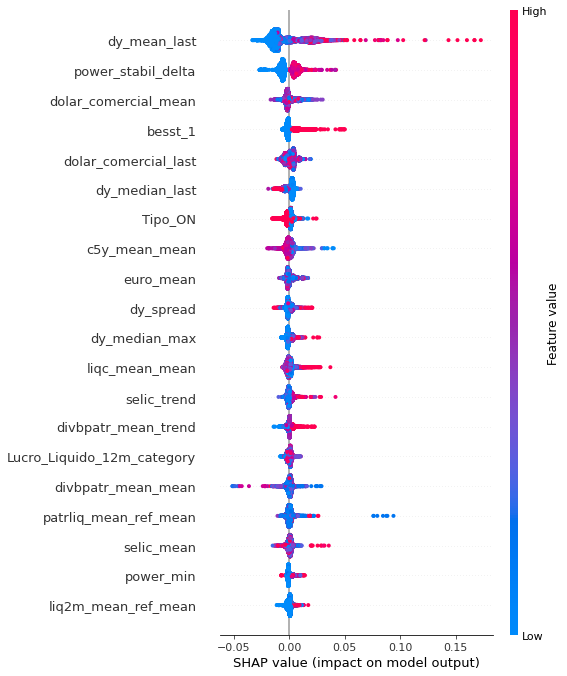

100%|===================| 15111/15167 [04:02<00:00]        

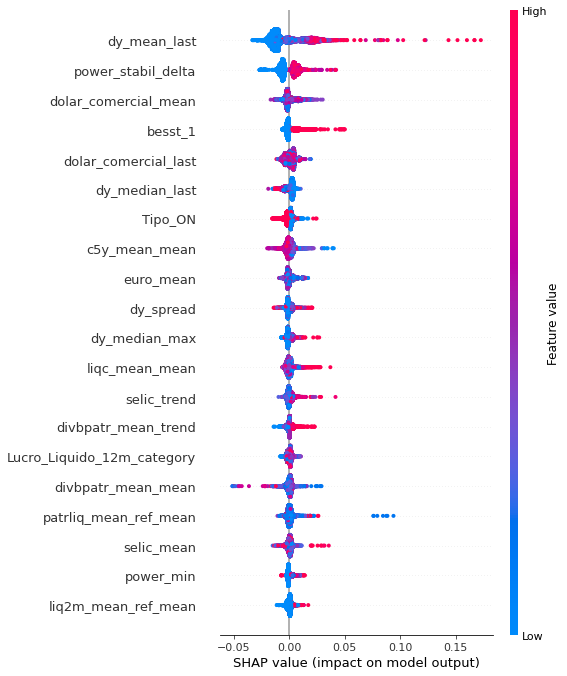

In [23]:
date = '2023-08-29'
sufix = ''
algorithm = 'LGBMRegressor'
transformer = 'Normalizer()'


feature_name, model_name, results_file, file_name_SHAP = get_analysis_inputs(date,sufix,algorithm,transformer)

df, df_to_pred, \
pipelines[feature_name], \
models[feature_name], \
transformers[feature_name], \
features[feature_name], \
shaps[feature_name] = analyse_resutls(df, df_to_pred, path, model_name, 
                                        results_file, 
                                        file_name_SHAP, 
                                        feature_name)

date = '2023-08-29'
sufix = ''
algorithm = 'XGBRegressor'
transformer = 'Normalizer()'

feature_name = model_name[11:].split('.')[0]

feature_name, model_name, results_file, file_name_SHAP = get_analysis_inputs(date,sufix,algorithm,transformer)

df, df_to_pred, \
pipelines[feature_name], \
models[feature_name], \
transformers[feature_name], \
features[feature_name], \
shaps[feature_name] = analyse_resutls(df, df_to_pred, path, model_name, 
                                        results_file, 
                                        file_name_SHAP, 
                                        feature_name)






In [24]:
date = '2023-08-29'
sufix = 'feature_selection'
algorithm = 'LGBMRegressor'
transformer = 'Normalizer()'

feature_name, model_name, results_file, file_name_SHAP = get_analysis_inputs(date,sufix,algorithm,transformer)

df, df_to_pred, \
pipelines[feature_name], \
models[feature_name], \
transformers[feature_name], \
features[feature_name], \
shaps[feature_name] = analyse_resutls(df, df_to_pred, path, model_name, 
                                        results_file, 
                                        file_name_SHAP, 
                                        feature_name)


date = '2023-08-29'
sufix = 'feature_selection_lgbm'
algorithm = 'LGBMRegressor'
transformer = 'Normalizer()'

feature_name, model_name, results_file, file_name_SHAP = get_analysis_inputs(date,sufix,algorithm,transformer)

df, df_to_pred, \
pipelines[feature_name], \
models[feature_name], \
transformers[feature_name], \
features[feature_name], \
shaps[feature_name] = analyse_resutls(df, df_to_pred, path, model_name, 
                                        results_file, 
                                        file_name_SHAP, 
                                        feature_name)

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
# path = '../data/03_models/out/'

# # '2023-08-29_LGBMRegressor_Normalizer()_feat_selection.pkl'

# model_name = '2023-08-29_LGBMRegressor_Normalizer()_feat_selection.pkl'
# results_file = '2023-08-29_LGBMRegressor_Normalizer()_results_feat_selection.json'
# file_name_SHAP = '2023-08-29_LGBMRegressor_Normalizer()_results_feat_selection_SHAP.pkl'

# df_to_pred['dy_pred_N_FS'], N_FS_pipeline, N_FS_model, N_FS_transformer, N_FS_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[N_FS_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# N_FS_shap = calculate_shap_values(N_FS_model, N_FS_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# path = '../data/03_models/out/'

# # '2023-08-29_LGBMRegressor_Normalizer()_feat_selection.pkl'

# model_name = '2023-08-29_XGBRegressor_Normalizer()_feat_selection.pkl'
# results_file = '2023-08-29_XGBRegressor_Normalizer()_results_feat_selection.json'
# file_name_SHAP = '2023-08-29_XGBRegressor_Normalizer()_results_feat_selection_SHAP.pkl'

# df_to_pred['dy_pred_XN_FS'], XN_FS_pipeline, XN_FS_model, XN_FS_transformer, XN_FS_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[XN_FS_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# XN_FS_shap = calculate_shap_values(XN_FS_model, N_FS_transformer, X_train, X_test, path, file_name_SHAP, plot=True)


# # '2023-08-29_LGBMRegressor_StandardScaler()_feat_selection.pkl' 

# model_name = '2023-08-29_LGBMRegressor_StandardScaler()_feat_selection.pkl'
# results_file = '2023-08-29_LGBMRegressor_StandardScaler()_results_feat_selection.json'
# file_name_SHAP = '2023-08-29_LGBMRegressor_StandardScaler()_results_feat_selection_SHAP.pkl'

# df_to_pred['dy_pred_S_FS'], S_FS_pipeline, S_FS_model, S_FS_transformer, S_FS_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[S_FS_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# S_FS_shap = calculate_shap_values(S_FS_model, N_FS_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# path = '../data/03_models/out/'

# # '2023-08-05_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'

# model_name = '2023-08-29_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'
# results_file = '2023-08-29_LGBMRegressor_Normalizer()_results_feat_selection_lgbm.json'
# file_name_SHAP = '2023-08-29_LGBMRegressor_Normalizer()_results_feat_selection_lgbm_SHAP.pkl'

# df_to_pred['dy_pred_N_FS_LGBM'], N_FS_LGBM_pipeline, N_FS_LGBM_model, N_FS_LGBM_transformer, N_FS_LGBM_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[N_FS_LGBM_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# N_FS_LGBM_shap = calculate_shap_values(N_FS_LGBM_model, N_FS_LGBM_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# # '2023-08-29_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl' 

# model_name = '2023-08-29_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl'
# results_file = '2023-08-29_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm.json'
# file_name_SHAP = '2023-08-29_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm_SHAP.pkl'

# df_to_pred['dy_pred_S_FS_LGBM'], S_FS_LGBM_pipeline, S_FS_LGBM_model, S_FS_LGBM_transformer, S_FS_LGBM_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[S_FS_LGBM_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# S_FS_LGBM_shap = calculate_shap_values(S_FS_LGBM_model, S_FS_LGBM_transformer, X_train, X_test, path, file_name_SHAP, plot=True)


## Recommend 20 best Stocks

In [ ]:
df_to_pred['Papel_root'] = df_to_pred['Papel'].str[:4]

df_recommend = df_to_pred[['Empresa','Papel','Papel_root','besst_1','besst_2','dy_label','pl_mean_last','cotacao_mean_last',
                            'dy_pred_N',
                            'dy_pred_XN',
                            'dy_pred_N_FS',
                            'dy_pred_S_FS']]\
                    .sort_values(by='dy_pred_N', ascending=False)\
                    .drop_duplicates(subset=['Papel_root'], keep='first')

KeyError: "['dy_pred_N_FS', 'dy_pred_S_FS'] not in index"

In [ ]:
# df_to_pred['Papel_root'] = df_to_pred['Papel'].str[:4]

# df_recommend = df_to_pred[['Empresa','Papel','Papel_root','besst_1','besst_2','dy_label','pl_mean_last','cotacao_mean_last',
#                             'dy_pred_N_FS',
#                             'dy_pred_XN_FS',
#                             'dy_pred_S_FS',
#                             'dy_pred_N_FS_LGBM',
#                             'dy_pred_S_FS_LGBM']]\
#                     .sort_values(by='dy_pred_N_FS', ascending=False)\
#                     .drop_duplicates(subset=['Papel_root'], keep='first')

In [ ]:
df_recomment = df_recommend[df_recommend['dy_label']<1]

In [ ]:
df_recommend.sort_values(by='dy_pred_N', ascending=False).iloc[:30]

Empresa  Papel Papel_root  besst_1  \
65479                       SONDOTECNICA S/A. PNB  SOND6       SOND      0.0   
9020                                    MONARK ON  BMKS3       BMKS      0.0   
79872                         BR PROPERTIES ON NM  BRPR3       BRPR      0.0   
68184                               TEMPO PART ON  TEMP3       TEMP      0.0   
21511                                      CR2 ON  CRDE3       CRDE      0.0   
88786                                SMILES ON NM  SMLS3       SMLS      0.0   
24580                               SANTANENSE ON  CTSA3       CTSA      0.0   
27631                   ELECTRO AÇO ALTONA S/A PN  EALT4       EALT      0.0   
71788               UNIPAR PARTICIPAÇÕES S.A. PNB  UNIP6       UNIP      0.0   
40608           YARA BRASIL FERTILIZANTES S.A. PN  ILMD4       ILMD      0.0   
17753            CESP CIA ENERGETICA SAO PAULO ON  CESP3       CESP      1.0   
18292   COMPANHIA DE GÁS DE SÃO PAULO - COMGÁS ON  CGAS3       CGAS      0.0   
83419                                CELESC PN N2  CLSC4       CLSC      1.0   
21633                              CREMER S.A. ON  CREM3       CREM      0.0   
29710                          AES ELETROPAULO PN  ELPL4       ELPL      1.0   
10381                             BANPARÁ S.A. ON  BPAR3       BPAR      1.0   
27916                                 ENCORPAR PN  ECPR4       ECPR      0.0   
55419                                Parana PN N1  PRBC4       PRBC      1.0   
64610                          EDITORA SARAIVA PN  SLED4       SLED      0.0   
19526                                 CEMIG PN N1  CMIG4       CMIG      1.0   
28793                               ELETROBRÁS ON  ELET3       ELET      1.0   
38339                           CIA HABITASUL PNA  HBTS5       HBTS      0.0   
4380                                    BAHEMA ON  BAHI3       BAHI      0.0   
21265                              COMPANY S/A ON  CPNY3       CPNY      0.0   
42611                              JOSAPAR S/A ON  JOPA3       JOPA      0.0   
75342                           WHIRLPOOL S.A. PN  WHRL4       WHRL      0.0   
35285  DUKE ENERGY INT,GERAÇÃO PARANAPANEMA SA ON  GEPA3       GEPA      1.0   
8350             BANCO MERCANTIL DO BRASIL S/A PN  BMEB4       BMEB      1.0   
62994                                Sofisa PN N1  SFSA4       SFSA      1.0   
38155                                   Helbor ON  HBOR3       HBOR      0.0   

       besst_2  dy_label  pl_mean_last  cotacao_mean_last  dy_pred_N  \
65479      0.0    0.9432      5.120000          45.000000   0.937592   
9020       0.0    0.9938     16.410000         378.750000   0.774638   
79872      0.0    0.6490     -4.896667           8.183333   0.645278   
68184      0.0    0.7008     11.360000           4.066667   0.632397   
21511      0.0    0.7353     -5.545000           1.370000   0.614989   
88786      0.0    0.9537      8.867500          45.877500   0.589209   
24580      0.0    0.5824      2.967500           4.735000   0.533292   
27631      0.0    0.6104      6.380000           4.695000   0.502889   
71788      1.0    0.5404      8.198333          41.865000   0.493743   
40608      1.0    0.6728     16.280000          30.000000   0.474071   
17753      0.0    0.4854     15.803333          13.570000   0.437248   
18292      0.0    0.4175      7.178000          43.272000   0.328182   
83419      0.0    0.4416    -15.880000          17.756667   0.326480   
21633      0.0    0.3182     29.040000          15.600000   0.317112   
29710      0.0    0.3571      6.615000           7.835000   0.306828   
10381      0.0    0.2894      5.550000         182.070000   0.301271   
27916      0.0    0.2886     17.900000          49.000000   0.295523   
55419      0.0    0.3133      5.690000          14.540000   0.288902   
64610      0.0    0.3346      0.952500           4.045000   0.288679   
19526      0.0    0.2919      2.355000           6.175000   0.276088   
28793      0.0    0.5277      5.080000          1

In [ ]:
df_recommend[(df_recommend['besst_1']==1)].sort_values(by='dy_pred_XN', ascending=False).iloc[:30]

Empresa  Papel Papel_root  besst_1  \
28793                               ELETROBRÁS ON  ELET3       ELET      1.0   
17753            CESP CIA ENERGETICA SAO PAULO ON  CESP3       CESP      1.0   
83419                                CELESC PN N2  CLSC4       CLSC      1.0   
29710                          AES ELETROPAULO PN  ELPL4       ELPL      1.0   
55419                                Parana PN N1  PRBC4       PRBC      1.0   
10381                             BANPARÁ S.A. ON  BPAR3       BPAR      1.0   
19526                                 CEMIG PN N1  CMIG4       CMIG      1.0   
8350             BANCO MERCANTIL DO BRASIL S/A PN  BMEB4       BMEB      1.0   
62994                                Sofisa PN N1  SFSA4       SFSA      1.0   
35285  DUKE ENERGY INT,GERAÇÃO PARANAPANEMA SA ON  GEPA3       GEPA      1.0   
23291                                  COSERN PNA  CSRN5       CSRN      1.0   
15931  CEB - COMPANHIA ENERGÉTICA DE BRASÍLIA PNA  CEBR5       CEBR      1.0   
31113               EQUATORIAL ENERGIA S.A. ON NM  EQTL3       EQTL      1.0   
800                                   AES ELPA ON  AELP3       AELP      1.0   
17151                                    CELPE ON  CEPE3       CEPE      1.0   
9244                         BANCO DO NORDESTE ON  BNBR3       BNBR      1.0   
53390                                     Pine PN  PINE4       PINE      1.0   
1128                                 AFLUENTE PNA  AFLU5       AFLU      1.0   
87515                               AFLUENTE T ON  AFLT3       AFLT      1.0   
86600                           AES TIETE E ON N2  TIET3       TIET      1.0   
22337    COMPANHIA DE SEGUROS ALIANÇA DA BAHIA PN  CSAB4       CSAB      1.0   
20996                                   COPEL PNA  CPLE5       CPLE      1.0   
28311     ELEKTRO ELETRICIDADE E SERVIÇOS S.A. PN  EKTR4       EKTR      1.0   
20199                CIA ENERG CEARA - COELCE PNB  COCE6       COCE      1.0   
61555                                  SANEPAR PN  SAPR4       SAPR      1.0   
7391                               BicBanco PN N1  BICB4       BICB      1.0   
35641                             AES TIETE SA ON  GETI3       GETI      1.0   
78756                                 CIELO ON NM  CIEL3       CIEL      1.0   
16793                                  COELBA PNA  CEEB5       CEEB      1.0   
30604               EDP ENERGIAS DO BRASIL S/A ON  ENBR3       ENBR      1.0   

       besst_2  dy_label  pl_mean_last  cotacao_mean_last  dy_pred_N  \
28793      0.0    0.5277      5.080000          13.960000   0.256346   
17753      0.0    0.4854     15.803333          13.570000   0.437248   
83419      0.0    0.4416    -15.880000          17.756667   0.326480   
29710      0.0    0.3571      6.615000           7.835000   0.306828   
55419      0.0    0.3133      5.690000          14.540000   0.288902   
10381      0.0    0.2894      5.550000         182.070000   0.301271   
19526      0.0    0.2919      2.355000           6.175000   0.276088   
8350       0.0    0.2560      5.123333           4.350000   0.212013   
62994      0.0    0.2547      6.456667           3.933333   0.211745   
35285      0.0    0.2184     30.320000          48.000000   0.215245   
23291      0.0    0.2177      5.670000           7.900000   0.210968   
15931      0.0    0.2000     -1.525000          23.000000   0.206407   
31113      0.0    0.2427      7.690000          11.700000   0.187745   
800        0.0    0.2031     48.510000           7.025000   0.176360   
17151      0.0    0.2383      4.910000          21.500000   0.185338   
9244       0.0    0.2037      6.020000          26.000000   0.178240   
53390      0.0    0.1898    -20.666667           3.146667   0.181145   
1128       0.0    0.2337     24.120000          10.600000   0.158614   
87515      0.0    0.1794     45.920000           6.990000   0.183020   
86600      0.0    0.2380     17.355000           2.137500   0.135400   
22337      0.0    0.1788   -130.225000          3

In [ ]:
dict_results = {'dy_pred_N'      :get_dy_metrics(df_recommend, 'dy_pred_N', 'besst_1', 1),
                'dy_pred_XN'     :get_dy_metrics(df_recommend, 'dy_pred_XN', 'besst_1', 1)}

dict_results2= {'dy_pred_N'      :get_dy_metrics(df_recommend, 'dy_pred_N', 'besst_2', 1),
                'dy_pred_XN'     :get_dy_metrics(df_recommend, 'dy_pred_XN', 'besst_2', 1)}

                

In [ ]:
# dict_results = {'dy_pred_N_FS'      :get_dy_metrics(df_recommend, 'dy_pred_N_FS', 'besst_1', 1),
#                 'dy_pred_XN_FS'     :get_dy_metrics(df_recommend, 'dy_pred_XN_FS', 'besst_1', 1),
#                 'dy_pred_S_FS'      :get_dy_metrics(df_recommend, 'dy_pred_S_FS', 'besst_1', 1),
#                 'dy_pred_N_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_N_FS_LGBM', 'besst_1', 1),
#                 'dy_pred_S_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_S_FS_LGBM', 'besst_1', 1)}

# dict_results2= {'dy_pred_N_FS'      :get_dy_metrics(df_recommend, 'dy_pred_N_FS', 'besst_2', 1),
#                 'dy_pred_XN_FS'     :get_dy_metrics(df_recommend, 'dy_pred_XN_FS', 'besst_2', 1),    
#                 'dy_pred_S_FS'      :get_dy_metrics(df_recommend, 'dy_pred_S_FS', 'besst_2', 1),
#                 'dy_pred_N_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_N_FS_LGBM', 'besst_2', 1),
#                 'dy_pred_S_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_S_FS_LGBM', 'besst_2', 1)}

                

In [ ]:
df_recommend['score'] = np.log(1 + df_recommend['dy_pred_N'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_N']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_XN'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_XN']['top10'].loc['dy_mean'])

In [ ]:
dict_results['score'] = get_dy_metrics(df_recommend, 'score', 'besst_1', 1)
dict_results2['score'] = get_dy_metrics(df_recommend, 'score', 'besst_2', 1)

In [ ]:
top_results = {}
for key in dict_results.keys():
    top_results[key] = df_recommend.sort_values(by=key, ascending=False)['dy_label'].iloc[:50].to_list()

for key in dict_results.keys():
    top_results[f'{key}_besst_1'] = df_recommend[df_recommend['besst_1']==1].sort_values(by=key, ascending=False)['dy_label'].iloc[:50].to_list()

for key in dict_results.keys():
    top_results[f'{key}_besst_2'] = df_recommend[df_recommend['besst_2']==1].sort_values(by=key, ascending=False)['dy_label'].iloc[:50].to_list()

df_top_results = pd.DataFrame(top_results)

In [ ]:
df_top_results_melt_top20 = pd.melt(df_top_results.iloc[:20][df_top_results.columns], 
                                value_name='DY_mean_top20', var_name='Model').groupby('Model').mean()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[:10][df_top_results.columns], 
                                value_name='DY_mean_top10', var_name='Model').groupby('Model').mean()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[:5][df_top_results.columns], 
                                value_name='DY_mean_top5', var_name='Model').groupby('Model').mean()               




df_top_results_melt_full = pd.concat([df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_top20 = pd.melt(df_top_results.iloc[:20][df_top_results.columns], 
                                value_name='DY_std_top20', var_name='Model').groupby('Model').std()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[:10][df_top_results.columns], 
                                value_name='DY_std_top10', var_name='Model').groupby('Model').std()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[:5][df_top_results.columns], 
                                value_name='DY_std_top5', var_name='Model').groupby('Model').std()  

df_top_results_melt_full = pd.concat([df_top_results_melt_full,df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_top20 = pd.melt(df_top_results.iloc[:20][df_top_results.columns], 
                                value_name='DY_median_top20', var_name='Model').groupby('Model').median()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[:10][df_top_results.columns], 
                                value_name='DY_median_top10', var_name='Model').groupby('Model').median()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[:5][df_top_results.columns], 
                                value_name='DY_median_top5', var_name='Model').groupby('Model').median()  

df_top_results_melt_full = pd.concat([df_top_results_melt_full,df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_full.head()

DY_mean_top5  DY_mean_top10  DY_mean_top20  DY_std_top5  \
Model                                                                         
dy_pred_N                0.80442        0.73818       0.545970     0.153944   
dy_pred_N_besst_1        0.37736        0.34355       0.270710     0.083741   
dy_pred_N_besst_2        0.36364        0.26668       0.198755     0.229872   
dy_pred_XN               0.85976        0.74424       0.577960     0.145084   
dy_pred_XN_besst_1       0.42502        0.34355       0.279095     0.088823   

                    DY_std_top10  DY_std_top20  DY_median_top5  \
Model                                                            
dy_pred_N               0.165720      0.232907          0.7353   
dy_pred_N_besst_1       0.106232      0.107075          0.3571   
dy_pred_N_besst_2       0.189986      0.152437          0.2527   
dy_pred_XN              0.160414      0.213512          0.9432   
dy_pred_XN_besst_1      0.106232      0.099802          0.4416   

                    DY_median_top10  DY_median_top20  
Model                                                 
dy_pred_N                   0.68680           0.5129  
dy_pred_N_besst_1           0.30260           0.2405  
dy_pred_N_besst_2           0.19905           0.1293  
dy_pred_XN                  0.68680           0.5614  
dy_pred_XN_besst_1          0.30260           0.2405

### Analysis for the overall stocks

In [ ]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_' not in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  DY_mean_top20  DY_std_top5  \
Model                                                                 
dy_pred_N        0.80442        0.73818        0.54597     0.153944   
dy_pred_XN       0.85976        0.74424        0.57796     0.145084   
score            0.85500        0.73818        0.57318     0.152930   

            DY_std_top10  DY_std_top20  DY_median_top5  DY_median_top10  \
Model                                                                     
dy_pred_N       0.165720      0.232907          0.7353           0.6868   
dy_pred_XN      0.160414      0.213512          0.9432           0.6868   
score           0.165720      0.219614          0.9432           0.6868   

            DY_median_top20  DY_sharpe_ratio_top5  DY_sharpe_ratio_top10  \
Model                                                                      
dy_pred_N            0.5129              5.225415               4.454373   
dy_pred_XN           0.5614              5.925927               4.639499   
score                0.5614              5.590790               4.454373   

            DY_sharpe_ratio_top20  
Model                              
dy_pred_N                2.344158  
dy_pred_XN               2.706915  
score                    2.609941

#### Top 5 Stocks

In [ ]:
plot_results(df_top_results_melt, 'DY_mean_top5', 'DY Mean Value - Top 5','rocket')

In [ ]:
plot_results(df_top_results_melt, 'DY_std_top5', 'DY Std Value - Top 5','viridis')

In [ ]:
plot_results(df_top_results_melt, 'DY_mean_top10', 'DY Std Value - Top 10','rocket')

#### Top 10 Stocks

In [ ]:
plot_results(df_top_results_melt, 'DY_mean_top10', 'DY Std Value - Top 10','rocket')

In [ ]:
plot_results(df_top_results_melt, 'DY_std_top10', 'DY Std Value - Top 10','viridis')

#### Top 20 Stocks

In [ ]:
plot_results(df_top_results_melt, 'DY_mean_top20', 'DY Mean Value - Top 20','rocket')

In [ ]:
plot_results(df_top_results_melt, 'DY_std_top20', 'DY Std Value - Top 20','viridis')

#### Overall results

In [ ]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [ ]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')

### Analysis for the BESST_1 Stocks (Sectors: A, B C ...)

In [ ]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_1' in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  DY_mean_top20  DY_std_top5  \
Model                                                                         
dy_pred_N_besst_1        0.37736        0.34355       0.270710     0.083741   
dy_pred_XN_besst_1       0.42502        0.34355       0.279095     0.088823   
score_besst_1            0.42024        0.34355       0.276135     0.096638   

                    DY_std_top10  DY_std_top20  DY_median_top5  \
Model                                                            
dy_pred_N_besst_1       0.106232      0.107075          0.3571   
dy_pred_XN_besst_1      0.106232      0.099802          0.4416   
score_besst_1           0.106232      0.101940          0.4416   

                    DY_median_top10  DY_median_top20  DY_sharpe_ratio_top5  \
Model                                                                        
dy_pred_N_besst_1            0.3026           0.2405              4.506250   
dy_pred_XN_besst_1           0.3026           0.2405              4.785006   
score_besst_1                0.3026           0.2405              4.348607   

                    DY_sharpe_ratio_top10  DY_sharpe_ratio_top20  
Model                                                             
dy_pred_N_besst_1                3.233963               2.528237  
dy_pred_XN_besst_1               3.233963               2.796494  
score_besst_1                    3.233963               2.708806

In [ ]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [ ]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')

### Analysis for the BESST_2 Stocks (Sectors: A, B C ...)

In [ ]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_2' in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  DY_mean_top20  DY_std_top5  \
Model                                                                         
dy_pred_N_besst_2        0.36364        0.26668       0.198755     0.229872   
dy_pred_XN_besst_2       0.39092        0.28351       0.198755     0.204102   
score_besst_2            0.39092        0.28351       0.199120     0.204102   

                    DY_std_top10  DY_std_top20  DY_median_top5  \
Model                                                            
dy_pred_N_besst_2       0.189986      0.152437          0.2527   
dy_pred_XN_besst_2      0.181495      0.152437          0.2815   
score_besst_2           0.181495      0.152182          0.2815   

                    DY_median_top10  DY_median_top20  DY_sharpe_ratio_top5  \
Model                                                                        
dy_pred_N_besst_2           0.19905           0.1293              1.581923   
dy_pred_XN_besst_2          0.22995           0.1293              1.915313   
score_besst_2               0.22995           0.1293              1.915313   

                    DY_sharpe_ratio_top10  DY_sharpe_ratio_top20  
Model                                                             
dy_pred_N_besst_2                1.403680               1.303852  
dy_pred_XN_besst_2               1.562085               1.303852  
score_besst_2                    1.562085               1.308436

In [ ]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [ ]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')

### Analysis for the overall Stocks between 11 and 30

In [ ]:
df_top_results_melt_top20 = pd.melt(df_top_results.iloc[10:30][df_top_results.columns], 
                                value_name='DY_mean_top20', var_name='Model').groupby('Model').mean()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[10:20][df_top_results.columns], 
                                value_name='DY_mean_top10', var_name='Model').groupby('Model').mean()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[10:15][df_top_results.columns], 
                                value_name='DY_mean_top5', var_name='Model').groupby('Model').mean()   

In [ ]:
df_top_results_melt_full = pd.concat([df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_top20 = pd.melt(df_top_results.iloc[10:30][df_top_results.columns], 
                                value_name='DY_std_top20', var_name='Model').groupby('Model').std()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[10:20][df_top_results.columns], 
                                value_name='DY_std_top10', var_name='Model').groupby('Model').std()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[10:15][df_top_results.columns], 
                                value_name='DY_std_top5', var_name='Model').groupby('Model').std()  

df_top_results_melt_full = pd.concat([df_top_results_melt_full,df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

In [ ]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_' not in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  DY_mean_top20  DY_std_top5  \
Model                                                                 
dy_pred_N        0.40396        0.35376       0.336105     0.066677   
dy_pred_XN       0.49092        0.41168       0.333485     0.066285   
score            0.50304        0.40818       0.336515     0.088882   

            DY_std_top10  DY_std_top20  DY_sharpe_ratio_top5  \
Model                                                          
dy_pred_N       0.070397      0.113918              6.058474   
dy_pred_XN      0.095213      0.105385              7.406204   
score           0.117713      0.113479              5.659638   

            DY_sharpe_ratio_top10  DY_sharpe_ratio_top20  
Model                                                     
dy_pred_N                5.025181               2.950411  
dy_pred_XN               4.323783               3.164444  
score                    3.467575               2.965444

In [ ]:
plot_results(df_top_results_melt, 'DY_mean_top10', 'DY Mean Value - Top 10','rocket')

In [ ]:
plot_results(df_top_results_melt, 'DY_std_top10', 'DY Std Value - Top 10','viridis')

In [ ]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [ ]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')